## **Multilayer Perceptron (From Scratch)**

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Starting Training (This uses NumPy, might take a moment)...
Epoch 0: Cost 0.1748
Epoch 5: Cost 0.0433
Epoch 10: Cost 0.0208
Epoch 15: Cost 0.0097
Epoch 20: Cost 0.0032

Final Test Accuracy: 98.08%


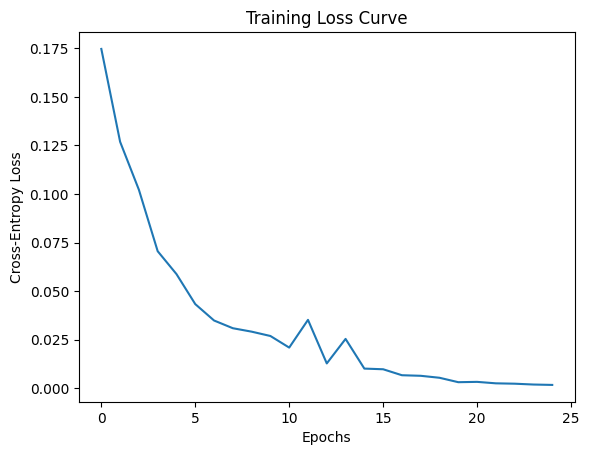

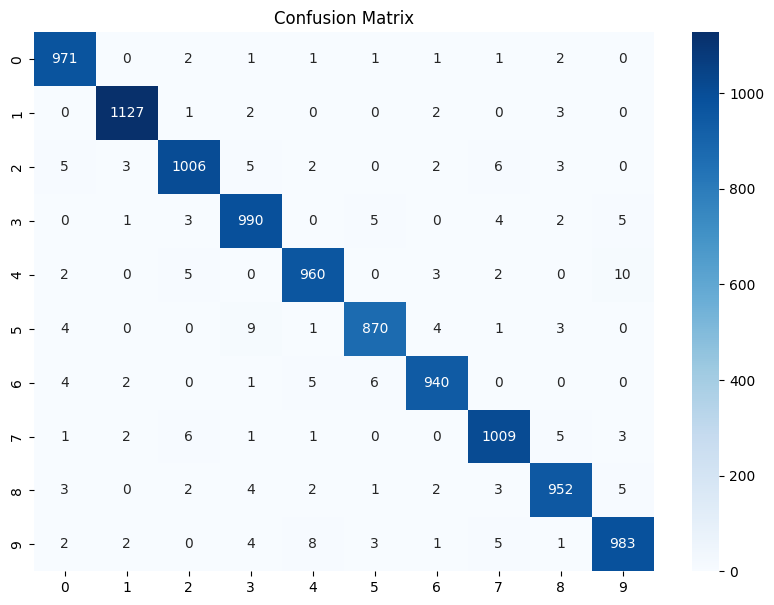


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Data Loading and Preprocessing
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Normalize to [0, 1]
    x_train = x_train.reshape(x_train.shape[0], -1).T / 255.0  # Shape: (784, 60000)
    x_test = x_test.reshape(x_test.shape[0], -1).T / 255.0    # Shape: (784, 10000)
    
    # One-hot encode labels
    y_train_enc = np.eye(10)[y_train].T
    y_test_enc = np.eye(10)[y_test].T
    
    return x_train, y_train_enc, x_test, y_test_enc, y_test

# 2. Activation Functions
def relu(Z):
    return np.maximum(0, Z)

def relu_deriv(Z):
    return Z > 0

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True)) # Stability fix
    return expZ / np.sum(expZ, axis=0, keepdims=True)

# 3. Neural Network Class
class MLP_From_Scratch:
    def __init__(self, layer_dims):
        self.layer_dims = layer_dims
        self.params = {}
        self.costs = []
        self.initialize_parameters_he()

    def initialize_parameters_he(self):
        np.random.seed(42)
        for l in range(1, len(self.layer_dims)):
            # He Initialization: sqrt(2 / n_in)
            self.params['W' + str(l)] = np.random.randn(self.layer_dims[l], self.layer_dims[l-1]) * np.sqrt(2/self.layer_dims[l-1])
            self.params['b' + str(l)] = np.zeros((self.layer_dims[l], 1))

    def forward_prop(self, X):
        caches = {}
        A = X
        L = len(self.layer_dims) - 1
        
        # Hidden Layers (ReLU)
        for l in range(1, L):
            Z = np.dot(self.params['W' + str(l)], A) + self.params['b' + str(l)]
            A_prev = A
            A = relu(Z)
            caches['Z' + str(l)] = Z
            caches['A' + str(l-1)] = A_prev
            
        # Output Layer (Softmax)
        Z_last = np.dot(self.params['W' + str(L)], A) + self.params['b' + str(L)]
        A_last = softmax(Z_last)
        caches['Z' + str(L)] = Z_last
        caches['A' + str(L-1)] = A
        
        return A_last, caches

    def compute_loss(self, A_last, Y):
        m = Y.shape[1]
        cost = -np.sum(Y * np.log(A_last + 1e-8)) / m
        return cost

    def backward_prop(self, A_last, Y, caches):
        grads = {}
        L = len(self.layer_dims) - 1
        m = Y.shape[1]
        
        # Output Layer Gradients
        dZ = A_last - Y
        grads['dW' + str(L)] = (1/m) * np.dot(dZ, caches['A' + str(L-1)].T)
        grads['db' + str(L)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        
        # Hidden Layers Gradients
        for l in reversed(range(1, L)):
            dA = np.dot(self.params['W' + str(l+1)].T, dZ)
            dZ = dA * relu_deriv(caches['Z' + str(l)])
            grads['dW' + str(l)] = (1/m) * np.dot(dZ, caches['A' + str(l-1)].T)
            grads['db' + str(l)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
            
        return grads

    def update_params(self, grads, learning_rate):
        L = len(self.layer_dims) - 1
        for l in range(1, L + 1):
            self.params['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
            self.params['b' + str(l)] -= learning_rate * grads['db' + str(l)]

    def train(self, X, Y, epochs=20, batch_size=64, learning_rate=0.1):
        m = X.shape[1]
        for i in range(epochs):
            # Mini-batch Logic
            permutation = np.random.permutation(m)
            X_shuffled = X[:, permutation]
            Y_shuffled = Y[:, permutation]
            
            for k in range(0, m, batch_size):
                X_batch = X_shuffled[:, k:k+batch_size]
                Y_batch = Y_shuffled[:, k:k+batch_size]
                
                A_last, caches = self.forward_prop(X_batch)
                grads = self.backward_prop(A_last, Y_batch, caches)
                self.update_params(grads, learning_rate)
            
            # Record cost at end of epoch
            full_pred, _ = self.forward_prop(X)
            cost = self.compute_loss(full_pred, Y)
            self.costs.append(cost)
            
            if i % 5 == 0:
                print(f"Epoch {i}: Cost {cost:.4f}")

    def predict(self, X):
        A_last, _ = self.forward_prop(X)
        return np.argmax(A_last, axis=0)

# --- EXECUTION ---
# 1. Load
x_train, y_train, x_test, y_test, y_test_labels = load_data()

# 2. Architecture: 784 -> 128 -> 64 -> 10
mlp = MLP_From_Scratch([784, 128, 64, 10])

# 3. Train
print("Starting Training (This uses NumPy, might take a moment)...")
mlp.train(x_train, y_train, epochs=25, batch_size=64, learning_rate=0.1)

# 4. Evaluation
predictions = mlp.predict(x_test)
accuracy = np.mean(predictions == y_test_labels)
print(f"\nFinal Test Accuracy: {accuracy * 100:.2f}%")

# 5. Visualization
plt.plot(mlp.costs)
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test_labels, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test_labels, predictions))